In [248]:
from IPython.display import HTML

def hide_code():
    return HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Toggle Code"></form>''')

hide_code()


# Appendice A: Importing CSVs into a DuckDB database

In [ ]:
import duckdb
import os
import pandas as pd
import re  # For cleaning column names

# Define paths
csv_folder = r"C:\Users\shres\Downloads\amplitude_export_2024\processed_csv"
db_path = r"C:\Users\shres\Downloads\amplitude_export_2024\amplitude_data.duckdb"

# Connect to DuckDB
con = duckdb.connect(db_path)

# Get column names from the first CSV file
csv_files = [os.path.join(csv_folder, f) for f in os.listdir(csv_folder) if f.endswith(".csv")]
sample_df = pd.read_csv(csv_files[0], nrows=5)  # Read first few rows

# Clean column names: Remove special characters
clean_columns = [re.sub(r"[^a-zA-Z0-9_]", "", col) for col in sample_df.columns]

# Rename columns in the sample DataFrame (for consistency)
sample_df.columns = clean_columns

# Create table in DuckDB with sanitized column names
create_table_query = f"""
CREATE TABLE events ({', '.join([f'{col} TEXT' for col in clean_columns])})
"""
con.execute("DROP TABLE IF EXISTS events")  # Ensure no conflicts
con.execute(create_table_query)

# Step 2: Load CSVs into DuckDB (Fix column names in every CSV before loading)
for file in csv_files:
    print(f"📥 Processing {file}...")

    # Read CSV and rename columns
    df = pd.read_csv(file)
    df.columns = clean_columns  # Ensure all column names match

    # Save to a temporary file before loading into DuckDB
    temp_file = file.replace(".csv", "_cleaned.csv")
    df.to_csv(temp_file, index=False)

    # Load into DuckDB
    con.execute(f"COPY events FROM '{temp_file}' (FORMAT CSV, HEADER TRUE)")
    print(f" Finished loading {file}")

print("All CSVs have been loaded into DuckDB successfully!")


# Appendix B : Table Information

In [57]:
df = con.execute("PRAGMA table_info(events)").fetchdf()
df


,cid,name,type,notnull,dflt_value,pk
0,0,insert_id,VARCHAR,False,None,False
1,1,amplitude_id,VARCHAR,False,None,False
2,2,app,VARCHAR,False,None,False
3,3,city,VARCHAR,False,None,False
4,4,client_event_time,VARCHAR,False,None,False
5,5,client_upload_time,VARCHAR,False,None,False
6,6,country,VARCHAR,False,None,False
7,7,data,VARCHAR,False,None,False
8,8,data_type,VARCHAR,False,None,False
9,9,device_family,VARCHAR,False,None,False


# Appendix C : Total Entries, Unique Users, and Total Sessions

In [165]:
import duckdb

# Connect to the DuckDB database
db_path = r"C:\Users\shres\Downloads\amplitude_export_2024\amplitude_data.duckdb"
con = duckdb.connect(db_path)

df_overview = con.execute("""
    SELECT COUNT(*) AS total_events,
           COUNT(DISTINCT user_id) AS total_users,
           COUNT(DISTINCT session_id) AS total_sessions
    FROM events
""").fetchdf()

df_overview


,total_events,total_users,total_sessions
0,15409437,2243,607879


# Appendix D: Range of Data

In [60]:
df_time_range = con.execute("""
    SELECT MIN(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) AS earliest_event,
           MAX(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) AS latest_event
    FROM events
""").fetchdf()

df_time_range


,earliest_event,latest_event
0,2023-06-15 21:30:21.880,2025-01-28 21:00:00.162


# Appendix E: Most common event types

In [62]:
df_event_types = con.execute("""
    SELECT event_type, COUNT(*) AS event_count
    FROM events
    GROUP BY event_type
    ORDER BY event_count DESC
    LIMIT 10
""").fetchdf()

df_event_types


,event_type,event_count
0,account-lines::widget:render,2719869
1,account-lines::configurable-table:render,1524746
2,account-lines:::view,1011812
3,dashboard:my-book:configurable-table:render,785355
4,dashboard:my-book:widget:render,750288
5,application-window-opened,733715
6,account:::view,730780
7,account-lines::layout:render,688435
8,dashboard:my-book::view,525136
9,action-center:action-details::view,348010


# Appendix F: Daily Active Users and Cumulative Users

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

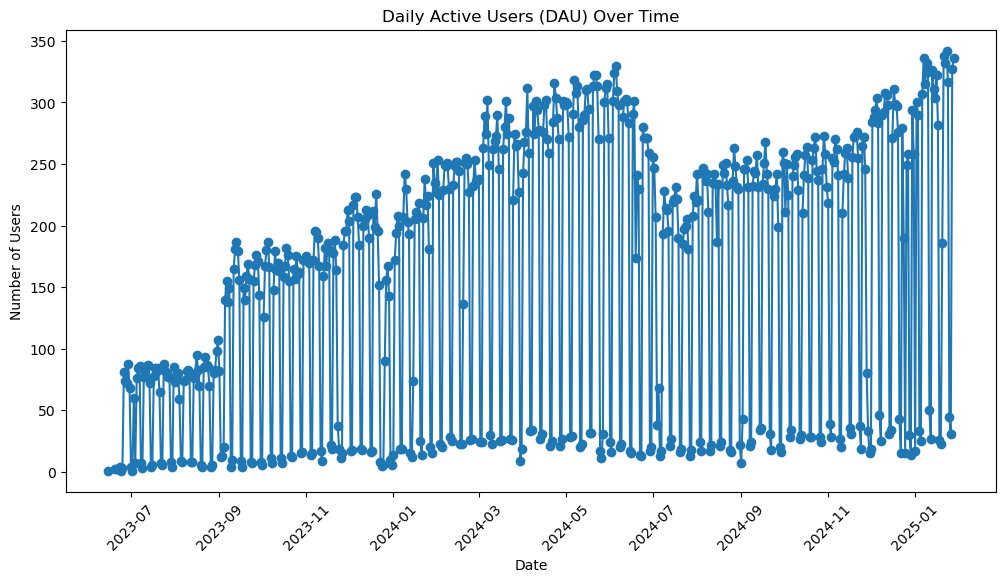

In [64]:
df_dau = con.execute("""
    SELECT CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS DATE) AS event_date,
           COUNT(DISTINCT user_id) AS daily_active_users
    FROM events
    GROUP BY event_date
    ORDER BY event_date
""").fetchdf()

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_dau['event_date'], df_dau['daily_active_users'], marker='o')
plt.title('Daily Active Users (DAU) Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Users')
plt.xticks(rotation=45)
plt.show()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

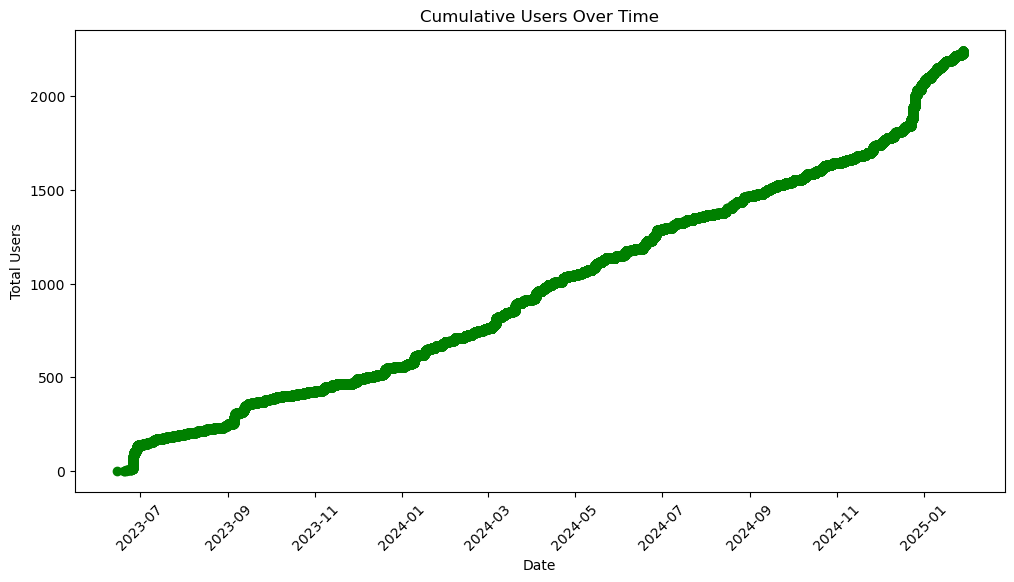

In [65]:
df_cumulative = con.execute("""
    WITH daily_users AS (
        SELECT CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS DATE) AS event_date,
               user_id
        FROM events
        GROUP BY event_date, user_id
    )
    SELECT event_date,
           COUNT(DISTINCT user_id) OVER (ORDER BY event_date ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS cumulative_users
    FROM daily_users
    ORDER BY event_date
""").fetchdf()

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_cumulative['event_date'], df_cumulative['cumulative_users'], marker='o', color='green')
plt.title('Cumulative Users Over Time')
plt.xlabel('Date')
plt.ylabel('Total Users')
plt.xticks(rotation=45)
plt.show()


# Appendix G: Event Distribution by Hour

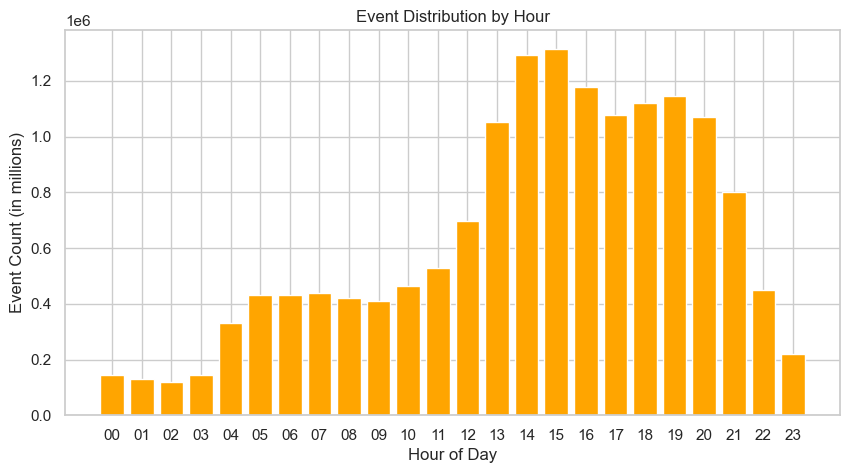

In [178]:
df_hourly = con.execute("""
    SELECT STRFTIME(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f'), '%H') AS event_hour,
           COUNT(*) AS event_count
    FROM events
    GROUP BY event_hour
    ORDER BY event_hour
""").fetchdf()

plt.figure(figsize=(10,5))
plt.bar(df_hourly['event_hour'], df_hourly['event_count'], color='orange')
plt.title('Event Distribution by Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Event Count (in millions)')
plt.show()

# Appendix H Top Users by Total Events

In [68]:
df_top_users = con.execute("""
    SELECT user_id, COUNT(*) AS total_events
    FROM events
    WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
    GROUP BY user_id
    ORDER BY total_events DESC
    LIMIT 10
""").fetchdf()

df_top_users


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,total_events
0,0c4896b7-08fa-4cb4-852f-27ad584f0864,343369
1,96521245-b6a9-4393-a42e-3e8e470f5e5f,241697
2,8dbcce7d-02e8-4556-b917-f5d3393bf859,215716
3,6066f244-0707-4e85-9fc5-70e6fefdea0b,200510
4,82b1d870-9646-4b85-898f-3754cc30538e,192109
5,b6071cc4-c091-4de4-82b1-722eff62b91c,186868
6,b2c2fd37-7866-4136-bce0-6f453452836b,172634
7,a883990d-2aa3-4644-9511-5f1c035717f2,168171
8,1b992a40-b2c3-4b69-a5bc-05711eeddd80,164436
9,b575b199-1108-46d1-b452-455d922394dd,154645


# Appendix I: Most Active User Sessions

In [69]:
df_session_length = con.execute("""
    SELECT user_id, session_id, COUNT(*) AS event_count
    FROM events
    WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
    GROUP BY user_id, session_id
    ORDER BY event_count DESC
    LIMIT 10
""").fetchdf()

df_session_length

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,session_id,event_count
0,3473675c-4986-4549-b988-ccb4ad18f605,1726222859279,14854
1,3473675c-4986-4549-b988-ccb4ad18f605,1726122006359,10637
2,3473675c-4986-4549-b988-ccb4ad18f605,1725907971092,9202
3,3473675c-4986-4549-b988-ccb4ad18f605,1726475713708,6378
4,bb8fa1af-a540-4d0f-a633-569c61f01281,1722862609519,5903
5,57ac3fc1-363b-4f0d-8802-e9cc93b47610,1721574311964,5803
6,3473675c-4986-4549-b988-ccb4ad18f605,1725889254062,5680
7,3473675c-4986-4549-b988-ccb4ad18f605,1725964537186,5671
8,3473675c-4986-4549-b988-ccb4ad18f605,1732607054975,3793
9,3473675c-4986-4549-b988-ccb4ad18f605,1726158010936,3676


# Appendix J: Initial Retention Calc Rate28 days

In [158]:
df_retention_rate = con.execute("""
    WITH first_session AS (
        SELECT user_id,
               MIN(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) AS first_session_start
        FROM events
        WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
        GROUP BY user_id
    ),
    user_sessions AS (
        SELECT e.user_id,
               MIN(STRPTIME(e.event_time, '%Y-%m-%d %H:%M:%S.%f')) AS session_start,
               e.session_id,
               f.first_session_start
        FROM events e
        JOIN first_session f ON e.user_id = f.user_id
        WHERE e.user_id IS NOT NULL AND e.user_id != 'EMPTY'
        GROUP BY e.user_id, e.session_id, f.first_session_start
    ),
    valid_return_sessions AS (
        SELECT user_id,
               session_id,
               session_start,
               first_session_start
        FROM user_sessions
        WHERE session_start > first_session_start
          AND session_start <= DATE_ADD(first_session_start, INTERVAL 28 DAY)
    )
    SELECT COUNT(DISTINCT user_id) AS retained_users,
           (SELECT COUNT(DISTINCT user_id) FROM first_session) AS total_users,
           ROUND((COUNT(DISTINCT user_id) * 100.0) / (SELECT COUNT(DISTINCT user_id) FROM first_session), 2) AS retention_rate_percentage
    FROM valid_return_sessions
""").fetchdf()

# Display retention rate
print(df_retention_rate)



FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

   retained_users  total_users  retention_rate_percentage
0            1434         2242                      63.96


# Appendix K: Event Categorization

In [38]:
# Enhanced categorization function
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply the enhanced categorization
df_event_types['enhanced_category'] = df_event_types['event_type'].apply(enhanced_categorize_event)

# Group and summarize by category
df_category_summary = df_event_types.groupby('enhanced_category')['event_count'].sum().reset_index().sort_values(by='event_count', ascending=False)

# View the new summary
df_category_summary


,enhanced_category,event_count
7,render,6609405
10,view,5206193
5,navigation,1317858
1,click,1177594
8,submission,327001
0,account_action,117366
3,edit/update,87485
4,filter/config,55835
6,other,39997
2,document,20888


# Appendix L: Events before Session_End

In [191]:
# Run the refined query to exclude 'session_end' as a preceding event
df_pre_session_end_cleaned = con.execute("""
    WITH ordered_events AS (
        SELECT user_id, session_id, event_type, event_time,
               LEAD(event_type) OVER (PARTITION BY session_id ORDER BY STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) AS next_event
        FROM events
        WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
    )
    SELECT event_type AS preceding_event, COUNT(*) AS count_before_session_end
    FROM ordered_events
    WHERE next_event = 'session_end'
      AND (event_type != 'session_end' AND event_type != 'session_start') -- Exclude session_end as preceding event
    GROUP BY preceding_event
    ORDER BY count_before_session_end DESC
    LIMIT 20
""").fetchdf()

df_pre_session_end_cleaned


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,preceding_event,count_before_session_end
0,account-lines::configurable-table:render,29909
1,account-lines::widget:render,23014
2,dashboard:my-book:configurable-table:render,17801
3,action-center:::close-click,8767
4,dashboard:my-book::view,5385
5,:all-accounts::view,5227
6,action-center:action-details::view,5105
7,account-lines:::change-rating-click,5078
8,account:::view,3875
9,::configurable-table:render,3364


| **Preceding Event**                             | **Drop-Off Count** | **Potential Insight**                                                                                     | **Optimization Ideas**                                         |
|-------------------------------------------------|--------------------|------------------------------------------------------------------------------------------------------------|---------------------------------------------------------------|
| `account-lines::configurable-table:render`      | 29,901             | Users might be **passively browsing** without taking action.                                               | Add **call-to-actions** post-render.                          |
| `account-lines::widget:render`                  | 23,023             | Similar to the above — passive viewing could lead to disengagement.                                         | Show **related tasks or insights**.                           |
| `dashboard:my-book:configurable-table:render`   | 17,803             | Users could be viewing key data but leaving afterward.                                                      | Introduce **next-step suggestions** post-dashboard view.      |
| `action-center:::close-click`                   | 8,767              | Users actively **close the action center** and then leave — indicates **task completion or disengagement**. | Show a **"Before You Go"** prompt.                            |
| `dashboard:my-book::view`                        | 5,386              | Users may be passively browsing or unsure of next steps.                                                     | Suggest **most-used features** or **quick tips**.              |
| `:all-accounts::view`                            | 5,247              | Users might browse account lists and leave.                                                                | Add **recommended actions** or **highlight key accounts**.    |
| `action-center:action-details::view`            | 5,107              | Users may review details and leave — possibly **task completion**.                                          | Prompt for **related tasks**.                                 |
| `account-lines:::change-rating-click`           | 5,076              | Users change a rating and then leave — perhaps **task-oriented users** finishing a job.                     | Suggest **similar tasks** post-action.                        |
| `account:::view`                                | 3,872              | Users view account details and exit — potential end-of-task.                                                | Highlight **related accounts** or **next best actions**.      |
| `::configurable-table:render`                   | 3,351              | Users may be overwhelmed by data or not finding what they need.                                             | Introduce **filters** or **key insights**.                    |
| `account-property-rating:perils:configurable-ta...` | 2,663           | Users engage with property rating but might not see clear next steps.                                       | Add **completion prompts** or **action buttons**.             |
| `submissions:all-policy::view`                  | 2,311              | Reviewing policies and exiting — possibly **done with task** or **found no actionable insights**.           | Suggest **related policies** or a **comparison tool**.        |
| `:all-accounts:configurable-table:render`       | 1,907              | Data-heavy views may cause disengagement.                                                                  | Implement **tooltips** or **summary views**.                   |
| `account-property-rating:perils::view`          | 1,882              | Users may leave after browsing property ratings.                                                            | Recommend **similar accounts** or **next steps**.             |
| `application-window-opened`                     | 1,798              | If users open a window and leave, they might be **confused** or didn’t find what they needed.               | Implement a **guided walkthrough** for new users.             |
| `action-center:action-details:response-form:sub...` | 1,754           | Users complete a form and exit — task completion.                                                           | Show a **“Next Recommended Task”** post-submission.          |
| `:all-accounts:widget:render`                   | 1,561              | Similar to other renders — passive engagement without follow-up.                                           | Highlight **interactive elements**.                          |
| `account-lines:::view`                          | 1,504              | Users view account lines but don’t take further action.                                                     | Suggest **quick edits** or **related tasks**.                 |
| `submissions:all-exposures::view`               | 1,400              | Users might review exposure data and leave.                                                                 | Highlight **exposure risks** or **suggest related policies**. |
| `action-center:::view`                          | 1,276              | Users view the action center but don’t proceed with tasks.                                                   | Show **priority tasks** or **prompt next steps**.             |


# Apendix M: Query to extract comprehensive user engagement metrics

In [88]:
# Revised DuckDB query using CTE to avoid nested aggregates
df_user_metrics = con.execute("""
    WITH session_durations AS (
        SELECT user_id, session_id,
               (EXTRACT(EPOCH FROM (MAX(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) - 
                                   MIN(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')))) / 60) AS session_duration
        FROM events
        WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
        GROUP BY user_id, session_id
    )
    SELECT e.user_id,
           COUNT(*) AS total_events,
           COUNT(DISTINCT e.session_id) AS total_sessions,
           AVG(s.session_duration) AS avg_session_duration,
           SUM(CASE WHEN e.event_type = 'session_end' THEN 1 ELSE 0 END) AS session_ends,
           COUNT(DISTINCT e.event_type) AS unique_events
    FROM events e
    LEFT JOIN session_durations s ON e.user_id = s.user_id AND e.session_id = s.session_id
    WHERE e.user_id IS NOT NULL AND e.user_id != 'EMPTY'
    GROUP BY e.user_id
""").fetchdf()

# Preview the data
df_user_metrics.head()


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,user_id,total_events,total_sessions,avg_session_duration,session_ends,unique_events
0,97ef6826-391f-4bdb-9ec0-cedd69486ff7,38377,2445,67.017043,1340.0,27
1,7cb296de-34f5-4c4e-9d64-51f7709e0444,91381,1970,81.072494,1849.0,50
2,97db667a-0269-4c59-a556-80f511003332,14590,1262,44.117715,1265.0,70
3,c15c83ab-a1be-44b4-8abb-3ef8bb449841,41792,2962,58.836585,2222.0,24
4,0d37224f-83c5-46a9-bd1c-2abe8fffb6f1,44081,2044,39.340211,1185.0,88


# Appendix N: Optimal Number of Clusters

 Optimal number of clusters (k): 4


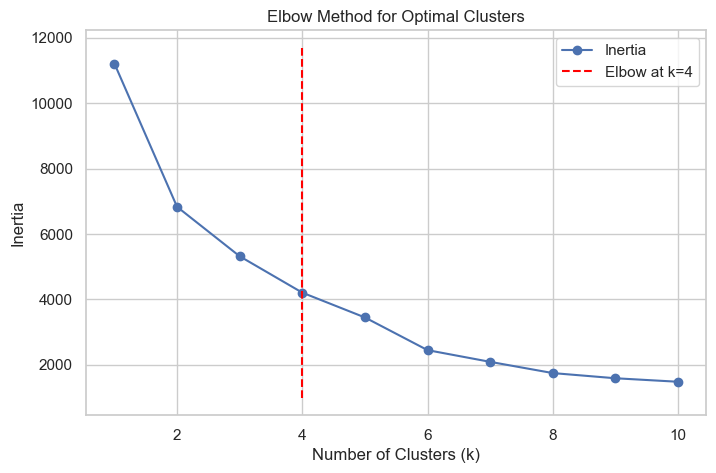

In [194]:


# Set the number of threads to avoid the memory leak
os.environ["OMP_NUM_THREADS"] = "9"
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns

# Select features for clustering
features = ['total_events', 'total_sessions', 'avg_session_duration', 'session_ends', 'unique_events']
X = df_user_metrics[features]

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use Elbow Method to find optimal k
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Find the elbow point using kneed
kneedle = KneeLocator(k_range, inertia, curve='convex', direction='decreasing')
optimal_k = kneedle.elbow

print(f" Optimal number of clusters (k): {optimal_k}")

# Plot Elbow Curve with the elbow marked
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', label='Inertia')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='red', label=f'Elbow at k={optimal_k}')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.legend()
plt.show()

# Appendix O: Clusterization of Users

In [199]:

from sklearn.cluster import KMeans
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Apply K-Means with k = 4
kmeans = KMeans(n_clusters=4, random_state=42)
df_user_metrics['cluster'] = kmeans.fit_predict(X_scaled)

# Check the cluster distribution
cluster_counts = df_user_metrics['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'User Count']
print(cluster_counts)


   Cluster  User Count
0        1        1638
1        0         499
2        3         103
3        2           2


# Appendix P: Applying Metrics for Cluster

🔹 Cluster Profile Summary:
    cluster  total_events_mean  total_events_median  total_events_min  \
0        0       10107.310621               5146.0                12   
1        1         171.295482                 31.0                 1   
2        2      108134.000000             108134.0             51832   
3        3       91451.330097              82356.0             37774   

   total_events_max  total_sessions_mean  total_sessions_median  \
0             59508           469.929860                  296.0   
1              9595            13.727717                    3.0   
2            164436         28931.000000                28931.0   
3            343369          2671.417476                 2462.0   

   total_sessions_min  total_sessions_max  avg_session_duration_mean  ...  \
0                   1                3174                  42.762630  ...   
1                   1                 573                   5.813301  ...   
2               21336               36526   

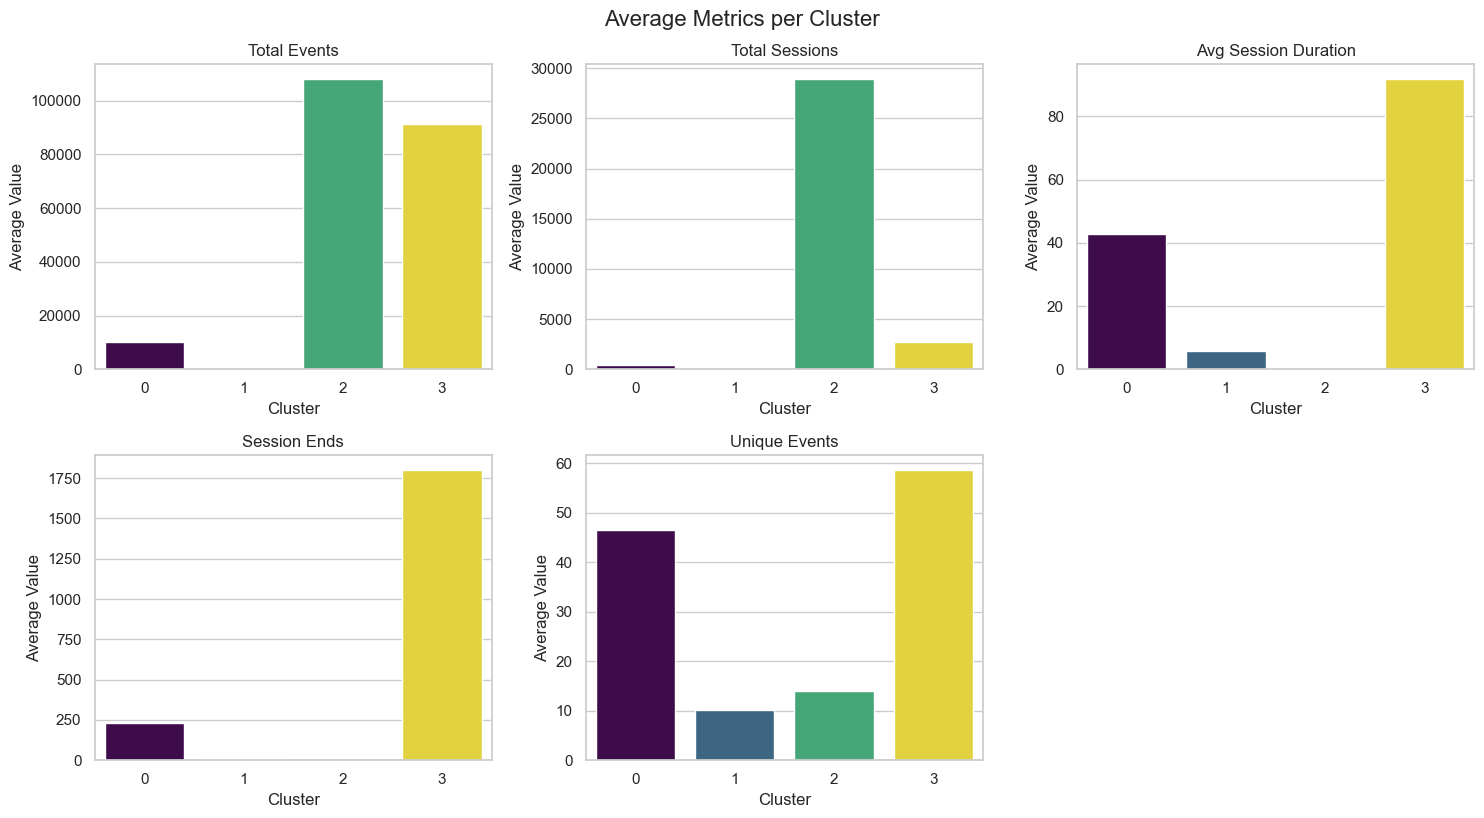

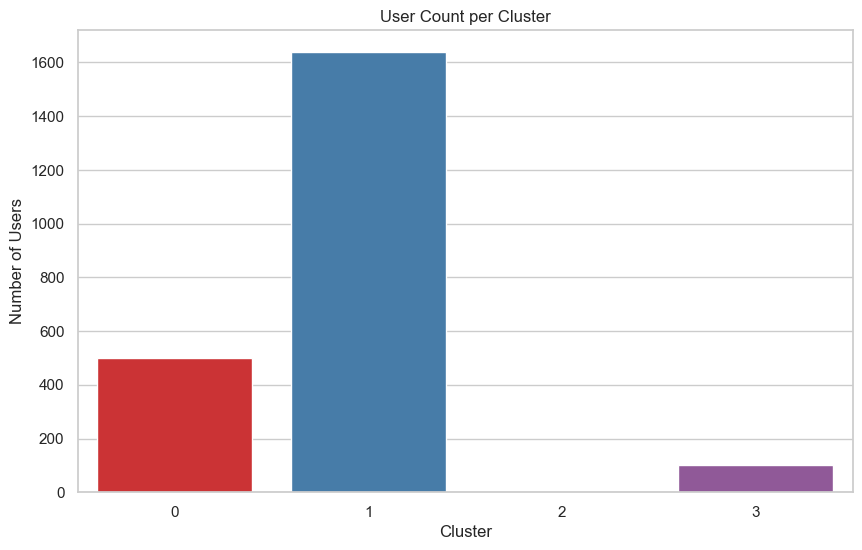

In [208]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


# Calculate summary statistics for each cluster
cluster_summary = df_user_metrics.groupby('cluster').agg({
    'total_events': ['mean', 'median', 'min', 'max'],
    'total_sessions': ['mean', 'median', 'min', 'max'],
    'avg_session_duration': ['mean', 'median', 'min', 'max'],
    'session_ends': ['mean', 'median', 'min', 'max'],
    'unique_events': ['mean', 'median', 'min', 'max'],
    'user_id': 'count'  # Number of users in each cluster
}).reset_index()

# Rename columns for clarity
cluster_summary.columns = ['_'.join(col).strip() if col[1] else col[0] for col in cluster_summary.columns]
cluster_summary.rename(columns={'user_id_count': 'User Count'}, inplace=True)

# Display the cluster profile table
print("🔹 Cluster Profile Summary:\n", cluster_summary)

# --------- Visualizations ---------

# Set up plot aesthetics
sns.set(style="whitegrid")

#  Barplot for average metrics per cluster (fixed future warning)
metrics = ['total_events_mean', 'total_sessions_mean', 'avg_session_duration_mean', 
           'session_ends_mean', 'unique_events_mean']

plt.figure(figsize=(15, 8))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(data=cluster_summary, x='cluster', y=metric, hue='cluster', palette='viridis', legend=False)
    plt.title(metric.replace('_mean', '').replace('_', ' ').title())
    plt.xlabel('Cluster')
    plt.ylabel('Average Value')

plt.tight_layout()
plt.suptitle('Average Metrics per Cluster', fontsize=16, y=1.02)
plt.show()




#⃣ Countplot to See User Distribution Across Clusters
plt.figure(figsize=(10, 6))
sns.countplot(data=df_user_metrics, x='cluster', palette='Set1')
plt.title('User Count per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Users')
plt.show()


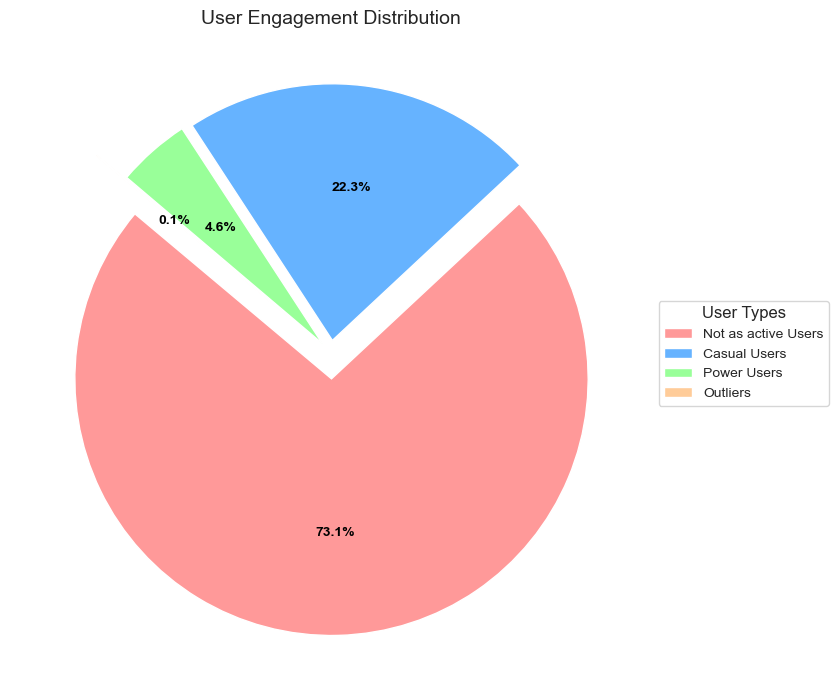

In [220]:
import matplotlib.pyplot as plt

# Cluster user counts from the profiling
cluster_counts = {
    'Not as active Users': 1638,
    'Casual Users': 499,
    'Power Users': 103,
    'Outliers': 2
}

# Prepare data for visualization
labels = list(cluster_counts.keys())
sizes = list(cluster_counts.values())
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
explode = (0.1, 0.05, 0.05, 0.2)  # Emphasize the largest and smallest segments

# Plot pie chart
fig, ax = plt.subplots(figsize=(10, 7))
wedges, texts, autotexts = ax.pie(sizes, explode=explode, colors=colors,
                                  autopct='%1.1f%%', startangle=140, textprops=dict(color="black"))

# Add a title
ax.set_title('User Engagement Distribution', fontsize=14)

# Add legend on the side
ax.legend(wedges, labels, title="User Types", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10)

# Enhance text aesthetics
plt.setp(autotexts, size=10, weight="bold")

plt.tight_layout()
plt.show()


# Cluster Insights
 
Cluster 1 — Inactive/Low Engagement Users (1638 Users, Largest Cluster)
Lowest total events and sessions.
Very low average session duration (~6 minutes).
Minimal interaction with platform features (low unique events).
 Insight:
This is the largest group but represents disengaged users. They are logging in but not interacting deeply.

 Actions:

Onboarding Improvements: Introduce feature walkthroughs or in-app tooltips to guide users.
Re-Engagement Campaigns: Use targeted email campaigns with tips, feature highlights, or success stories.
Gamification: Implement reward systems for increased platform activity.

Cluster 0 — Casual Users (499 Users)
Moderate activity with decent average session duration (~42 minutes).
A fair number of unique events but relatively low total events and sessions.
 Insight:
These users engage occasionally but aren’t deeply invested.

 Actions:

Feature Promotion: Recommend underused features that align with their current activity.
Personalized Nudges: Use in-app notifications to suggest next steps based on past actions.
Surveys: Collect feedback on potential pain points or missing features.


Cluster 3 — Power Users (103 Users)
High total events and sessions.
Longest average session duration (~92 minutes).
High diversity in event usage (unique events ~58).
 Insight:
These users are highly engaged and likely see strong value in the platform.

 Actions:

Beta Testers: Involve them in beta-testing new features.
Advanced Analytics: Offer detailed reporting or premium features.
Retention Strategy: Ensure continuous value — loyalty programs, early access to features.


Cluster 2 — Outliers (2 Users)
Extremely high total events and sessions but very few users.
Likely system users, bots, or outliers.
 Insight:
These users might skew data. Analyze if they represent legitimate usage.

 Actions:

Data Validation: Verify if these users are real or bots.
Separate Reporting: Exclude outliers when evaluating platform performance.
 
 
 Overall Platform Trends
 
High Inactivity Rate: ~75% of users fall into low-engagement categories (Cluster 1).

Strong Potential with Power Users: Though a small group, Power Users show the platform’s potential value when fully utilized.

User Drop-Off: There’s a big gap between casual users and power users—many users never make it past basic engagement.

 Key Recommendations
 
Focus on Onboarding: Smooth the user journey from inactive → casual → power user.
Nurture Power Users: Power Users are key brand advocates—keep them engaged with exclusive features or rewards.
Increase Stickiness for Casual Users: Build hooks (e.g., notifications, goal tracking) to pull casual users into deeper engagement.

# Appendix Q: Regional Drop Offs

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

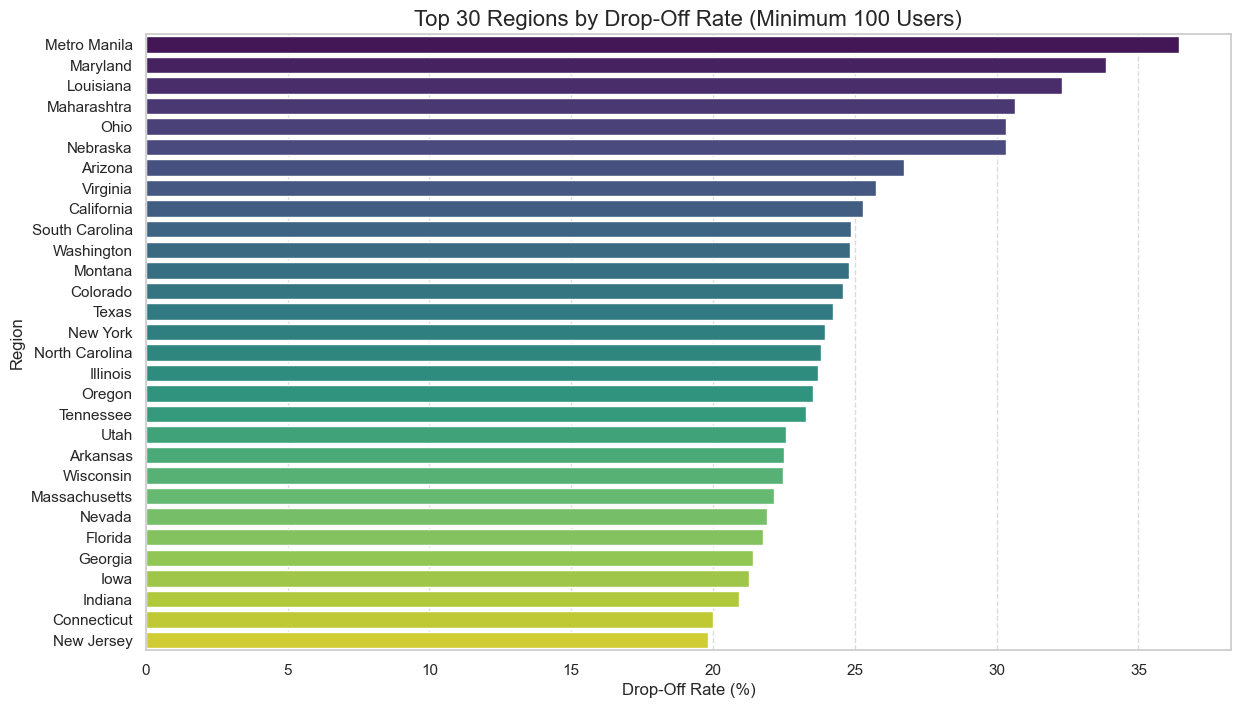

In [224]:

df_segment_drops_full = con.execute("""
    WITH ordered_events AS (
        SELECT user_id, session_id, event_type, region, device_type,
               STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS event_time,
               LEAD(event_type) OVER (PARTITION BY user_id, session_id ORDER BY STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f')) AS next_event
        FROM events
        WHERE user_id IS NOT NULL AND user_id != 'EMPTY'
    ),
    drop_offs AS (
        SELECT user_id, event_type AS source_event, region, device_type,
               CASE WHEN next_event IS NULL THEN 1 ELSE 0 END AS drop_off
        FROM ordered_events
    )
    SELECT source_event, region, device_type,
           COUNT(DISTINCT user_id) AS total_users,
           COUNT(DISTINCT CASE WHEN drop_off = 1 THEN user_id END) AS drop_offs,
           ROUND((COUNT(DISTINCT CASE WHEN drop_off = 1 THEN user_id END) * 100.0) / 
                 NULLIF(COUNT(DISTINCT user_id), 0), 2) AS drop_off_rate
    FROM drop_offs
    GROUP BY source_event, region, device_type
    ORDER BY drop_off_rate DESC, total_users DESC
""").fetchdf()


import matplotlib.pyplot as plt
import seaborn as sns

# Define a minimum user threshold to filter regions
min_users_threshold = 100  # You can adjust this threshold based on your data

# Filter regions with total users above the threshold
filtered_regions = df_segment_drops_full.groupby('region').agg({
    'drop_off_rate': 'mean', 
    'total_users': 'sum'
}).reset_index()

# Apply the filter
filtered_regions = filtered_regions[filtered_regions['total_users'] >= min_users_threshold]

# Sort by drop-off rate and get top 30
top_30_filtered_regions = filtered_regions.sort_values('drop_off_rate', ascending=False).head(30)

# Bar plot: Drop-Off Rate by Region
plt.figure(figsize=(14, 8))
sns.barplot(data=top_30_filtered_regions, x='drop_off_rate', y='region', palette='viridis')

# Plot Titles and Labels
plt.title("Top 30 Regions by Drop-Off Rate (Minimum 100 Users)", fontsize=16)
plt.xlabel("Drop-Off Rate (%)")
plt.ylabel("Region")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# Appendix R: Windows vs Non Windows Relative Risk

Mean Session Time: 13.91 minutes

Relative Risk Analysis: Windows vs. Non-Windows Devices
   windows_above  windows_below  non_windows_above  non_windows_below  \
0       120248.0       348955.0             8811.0            77203.0   

   relative_risk  
0       2.501849  


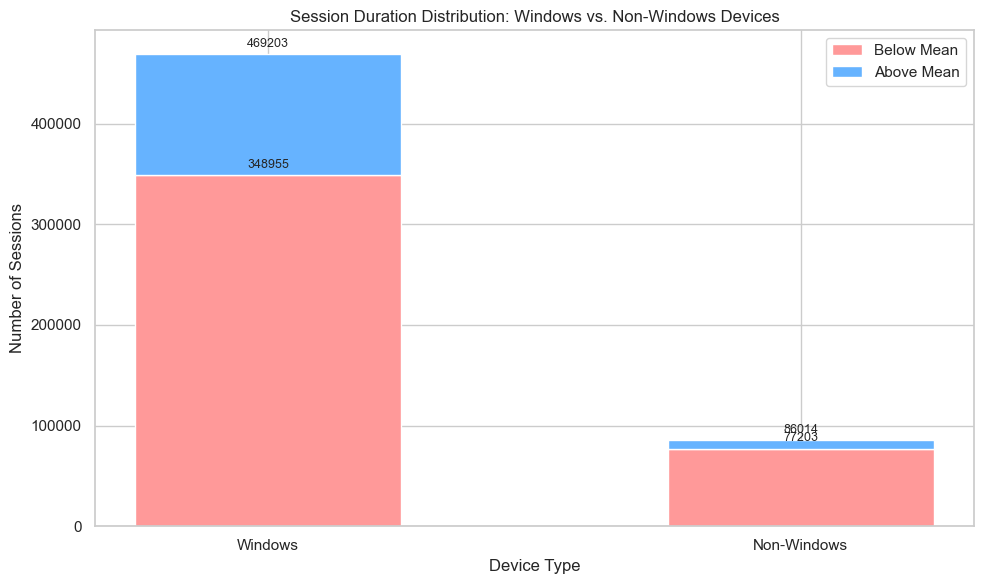

In [245]:
# Step 1: Calculate Mean Session Time
mean_session_query = """
    WITH session_durations AS (
        SELECT session_id, user_id, device_type,
               (EPOCH(MAX(CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS TIMESTAMP))) -
                EPOCH(MIN(CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS TIMESTAMP)))) / 60 AS session_duration_minutes
        FROM events
        WHERE session_id IS NOT NULL AND user_id IS NOT NULL
        GROUP BY session_id, user_id, device_type
    )
    SELECT AVG(session_duration_minutes) AS mean_session_duration_minutes
    FROM session_durations
"""

# Run the query to get the mean session time
mean_session_time = con.execute(mean_session_query).fetchdf()['mean_session_duration_minutes'][0]
print(f"Mean Session Time: {mean_session_time:.2f} minutes")

# Step 2: Classify Sessions Based on Mean & Calculate Relative Risk
relative_risk_query = f"""
    WITH session_durations AS (
        SELECT session_id, user_id, device_type,
               (EPOCH(MAX(CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS TIMESTAMP))) -
                EPOCH(MIN(CAST(STRPTIME(event_time, '%Y-%m-%d %H:%M:%S.%f') AS TIMESTAMP)))) / 60 AS session_duration_minutes
        FROM events
        WHERE session_id IS NOT NULL AND user_id IS NOT NULL
        GROUP BY session_id, user_id, device_type
    ),
    classified_sessions AS (
        SELECT *,
               CASE WHEN session_duration_minutes >= {mean_session_time}
                    THEN 'Above Mean' ELSE 'Below Mean' END AS session_category
        FROM session_durations
    ),
    device_counts AS (
        SELECT device_type,
               session_category,
               COUNT(*) AS session_count
        FROM classified_sessions
        GROUP BY device_type, session_category
    ),
    aggregated_counts AS (
        SELECT 
            SUM(CASE WHEN device_type = 'Windows' AND session_category = 'Above Mean' THEN session_count ELSE 0 END) AS windows_above,
            SUM(CASE WHEN device_type = 'Windows' AND session_category = 'Below Mean' THEN session_count ELSE 0 END) AS windows_below,
            SUM(CASE WHEN device_type != 'Windows' AND session_category = 'Above Mean' THEN session_count ELSE 0 END) AS non_windows_above,
            SUM(CASE WHEN device_type != 'Windows' AND session_category = 'Below Mean' THEN session_count ELSE 0 END) AS non_windows_below
        FROM device_counts
    )
    SELECT *,
           (CAST(windows_above AS DOUBLE) / (windows_above + windows_below)) AS windows_proportion_above,
           (CAST(non_windows_above AS DOUBLE) / (non_windows_above + non_windows_below)) AS non_windows_proportion_above,
           ((CAST(windows_above AS DOUBLE) / (windows_above + windows_below)) / 
           (CAST(non_windows_above AS DOUBLE) / (non_windows_above + non_windows_below))) AS relative_risk
    FROM aggregated_counts
"""

# Run the query to calculate relative risk
relative_risk_df = con.execute(relative_risk_query).fetchdf()

# Display Results
print("\nRelative Risk Analysis: Windows vs. Non-Windows Devices")
print(relative_risk_df[['windows_above', 'windows_below', 'non_windows_above', 'non_windows_below', 'relative_risk']])

# --------- Matplotlib Stacked Bar Chart (for HTML Export) ---------
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for Matplotlib
device_types = ['Windows', 'Non-Windows']
above_mean = [relative_risk_df['windows_above'][0], relative_risk_df['non_windows_above'][0]]
below_mean = [relative_risk_df['windows_below'][0], relative_risk_df['non_windows_below'][0]]

# Set up the plot
x = np.arange(len(device_types))  # Label locations
width = 0.5  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Plot Below Mean
bars_below = ax.bar(x, below_mean, width, label='Below Mean', color='#FF9999')

# Plot Above Mean stacked on top
bars_above = ax.bar(x, above_mean, width, bottom=below_mean, label='Above Mean', color='#66B3FF')

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Device Type')
ax.set_ylabel('Number of Sessions')
ax.set_title('Session Duration Distribution: Windows vs. Non-Windows Devices')
ax.set_xticks(x)
ax.set_xticklabels(device_types)
ax.legend()

# Add data labels
for bar in bars_below + bars_above:
    height = bar.get_height() + (bar.get_y() if bar.get_y() else 0)
    ax.annotate(f'{int(height)}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Offset label above bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


# Appendix S: Random Sampling

In [232]:
df_sampled_events = con.execute("""
    SELECT *
    FROM events
    USING SAMPLE 100000
""").fetchdf()

# Verify the sample size
print(f"Sampled Rows: {len(df_sampled_events)}")
df_sampled_events.head()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sampled Rows: 100000


,insert_id,amplitude_id,app,city,client_event_time,client_upload_time,country,data,data_type,device_family,...,os_version,platform,processed_time,region,server_received_time,server_upload_time,session_id,user_id,user_properties,uuid
0,4585c800-61b4-4d93-8626-7e13f9079cff,857540522587,591532,Nashville,2024-09-18 13:49:41.779000,2024-09-18 13:49:42.898000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,128,Web,2024-09-18 13:49:44.023000,Tennessee,2024-09-18 13:49:42.898000,2024-09-18 13:49:42.901000,1726665340871,5c1c0314-8e7d-41f6-80d9-c5fcc0e001d5,"{'businessUnit': ['Xceedance Modeling'], 'init...",dc29461e-a67a-4e35-b492-cc3765129833
1,ec0bb1dc-8ec0-43c4-a91a-7c22442cb96f,857540546868,591532,Nashville,2024-08-14 16:20:27.521000,2024-08-14 16:20:28.062000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,127,Web,2024-08-14 16:20:28.519000,Tennessee,2024-08-14 16:20:28.062000,2024-08-14 16:20:28.064000,1723649398618,26e44ff7-4f44-446e-a5d1-38a9b3a79dd9,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",ac916196-0f57-4907-865d-47eeb8011fc6
2,6c8b9427-d0b5-4719-8c66-29a2a45ca9b5,857545077999,591532,Trumbull,2024-08-30 15:07:45.068000,2024-08-30 15:07:46.700000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Mac OS X,...,128,Web,2024-08-30 15:07:47.578000,Connecticut,2024-08-30 15:07:46.700000,2024-08-30 15:07:46.701000,1725030465088,27badcb0-1792-4274-ac78-ef9d9a90daaf,"{'businessUnit': ['Test 2 cahnged'], 'roles': ...",09c68bf6-7aeb-4563-bfac-3f8e754bbb2a
3,a14c2703-df59-4360-a308-6bbd636cd7e4,857540436153,591532,Washington,2025-01-18 06:31:34.906000,2025-01-18 06:31:36.080000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Linux,...,131,Web,2025-01-18 06:31:37.100000,Virginia,2025-01-18 06:31:36.080000,2025-01-18 06:31:36.095000,1737181880382,1b992a40-b2c3-4b69-a5bc-05711eeddd80,"{'businessUnit': [], 'initial_utm_medium': 'EM...",657efcd7-9dd2-443b-8746-8a825a743bc7
4,b6ee6e78-0ad5-4d22-a82e-5c9ddd0cf976,898343690247,591532,Littleton,2024-09-06 22:44:02.634000,2024-09-06 22:44:03.867000,United States,"{'path': '/2/httpapi', 'group_first_event': {}...",event,Windows,...,128,Web,2024-09-06 22:44:05.569000,Colorado,2024-09-06 22:44:03.867000,2024-09-06 22:44:03.869000,1725657597386,d22dbf32-56cf-47ad-bc72-39c9e7b42572,"{'initial_utm_medium': 'EMPTY', 'initial_refer...",34767bcc-6dc7-4bd2-a911-d529d534958f


# Appendix T: Casual Interference / Propensity Score

Mean Session Duration: 12.45 minutes
engaged
0    70077
1    30052
Name: count, dtype: int64


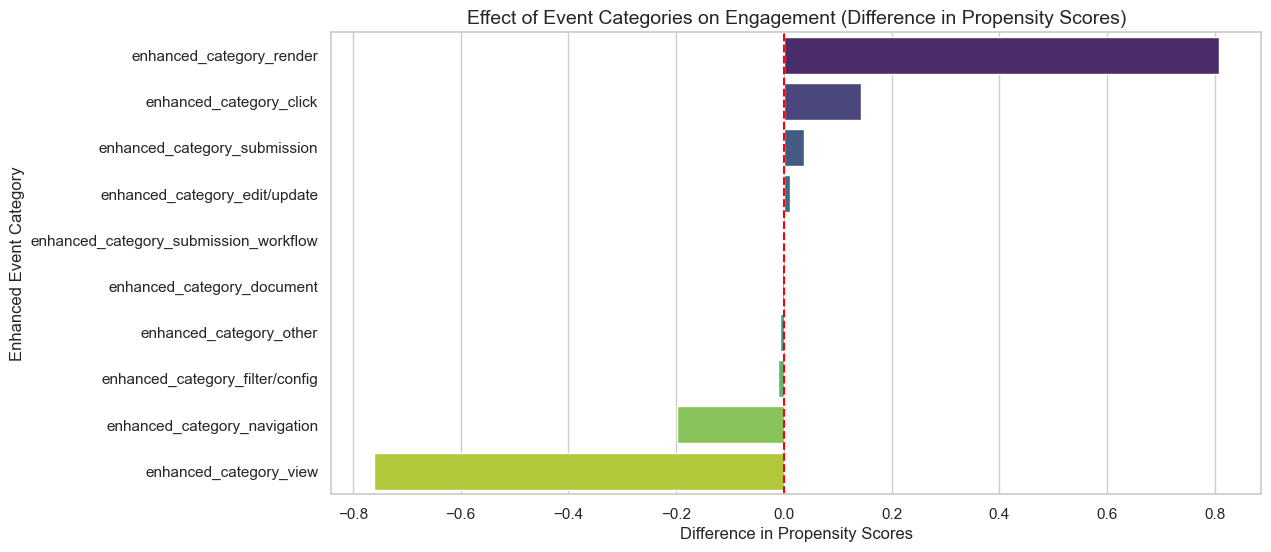

                                       Not Engaged   Engaged  Difference
enhanced_category_render                  0.000000  0.808074    0.808074
enhanced_category_click                   0.000000  0.143931    0.143931
enhanced_category_submission              0.000000  0.037475    0.037475
enhanced_category_edit/update             0.000000  0.010520    0.010520
enhanced_category_submission_workflow     0.000044  0.000000   -0.000044
enhanced_category_document                0.003386  0.000000   -0.003386
enhanced_category_other                   0.007259  0.000000   -0.007259
enhanced_category_filter/config           0.010379  0.000000   -0.010379
enhanced_category_navigation              0.199199  0.000000   -0.199199
enhanced_category_view                    0.761231  0.000000   -0.761231


In [235]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Step 1: Convert 'event_time' to datetime
df_sampled_events['event_time'] = pd.to_datetime(df_sampled_events['event_time'])

# Step 2: Calculate session durations (in minutes)
df_session_duration = df_sampled_events.groupby(['session_id', 'user_id', 'device_type']).agg(
    session_start=('event_time', 'min'),
    session_end=('event_time', 'max')
).reset_index()

# Calculate duration in minutes
df_session_duration['session_duration_minutes'] = (
    (df_session_duration['session_end'] - df_session_duration['session_start']).dt.total_seconds() / 60
)

# Step 3: Calculate the mean session duration
mean_session_duration = df_session_duration['session_duration_minutes'].mean()
print(f"Mean Session Duration: {mean_session_duration:.2f} minutes")

# Step 4: Classify sessions based on the mean
df_session_duration['engaged'] = np.where(df_session_duration['session_duration_minutes'] >= mean_session_duration, 1, 0)

#  Drop existing 'engaged' column if it exists before merging
if 'engaged' in df_sampled_events.columns:
    df_sampled_events.drop(columns=['engaged'], inplace=True)

# Step 5: Merge engagement classification back to original data
df_sampled_events = pd.merge(df_sampled_events, df_session_duration[['session_id', 'engaged']], on='session_id', how='left')

# Handle missing values in 'engaged' column
df_sampled_events['engaged'] = df_sampled_events['engaged'].fillna(0).astype(int)

# Check engagement distribution
print(df_sampled_events['engaged'].value_counts())

# Step 6: Enhanced Event Categorization
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply enhanced categorization
df_sampled_events['enhanced_category'] = df_sampled_events['event_type'].apply(enhanced_categorize_event)

# Step 7: Prepare Data for PSM
# One-hot encode event categories
df_psm = pd.get_dummies(df_sampled_events, columns=['enhanced_category'], drop_first=True)

# Step 8: Propensity Score Estimation
features = [col for col in df_psm.columns if col.startswith('enhanced_category_')]
X = df_psm[features]
y = df_psm['engaged']

# Logistic Regression for Propensity Scores
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X, y)
df_psm['propensity_score'] = log_reg.predict_proba(X)[:, 1]

# Step 9: Nearest Neighbor Matching
nn = NearestNeighbors(n_neighbors=1)
nn.fit(df_psm[['propensity_score']])
distances, indices = nn.kneighbors(df_psm[['propensity_score']])

# Create matched dataset
df_psm['matched_index'] = indices.flatten()
df_matched = df_psm.iloc[df_psm['matched_index']]

# Step 10: Analyze the Effect of Event Categories on Engagement
effect_summary = df_matched.groupby('engaged')[features].mean().T
effect_summary.columns = ['Not Engaged', 'Engaged']
effect_summary['Difference'] = effect_summary['Engaged'] - effect_summary['Not Engaged']

# Step 12: Bar Plot for Effect Sizes
effect_summary_sorted = effect_summary.sort_values(by='Difference', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(y=effect_summary_sorted.index, x=effect_summary_sorted['Difference'], palette='viridis')
plt.title('Effect of Event Categories on Engagement (Difference in Propensity Scores)', fontsize=14)
plt.xlabel('Difference in Propensity Scores')
plt.ylabel('Enhanced Event Category')
plt.axvline(0, color='red', linestyle='--')
plt.show()

# Display Effect Summary
print(effect_summary_sorted)


# Appendix U: User Journey: Markov Chains

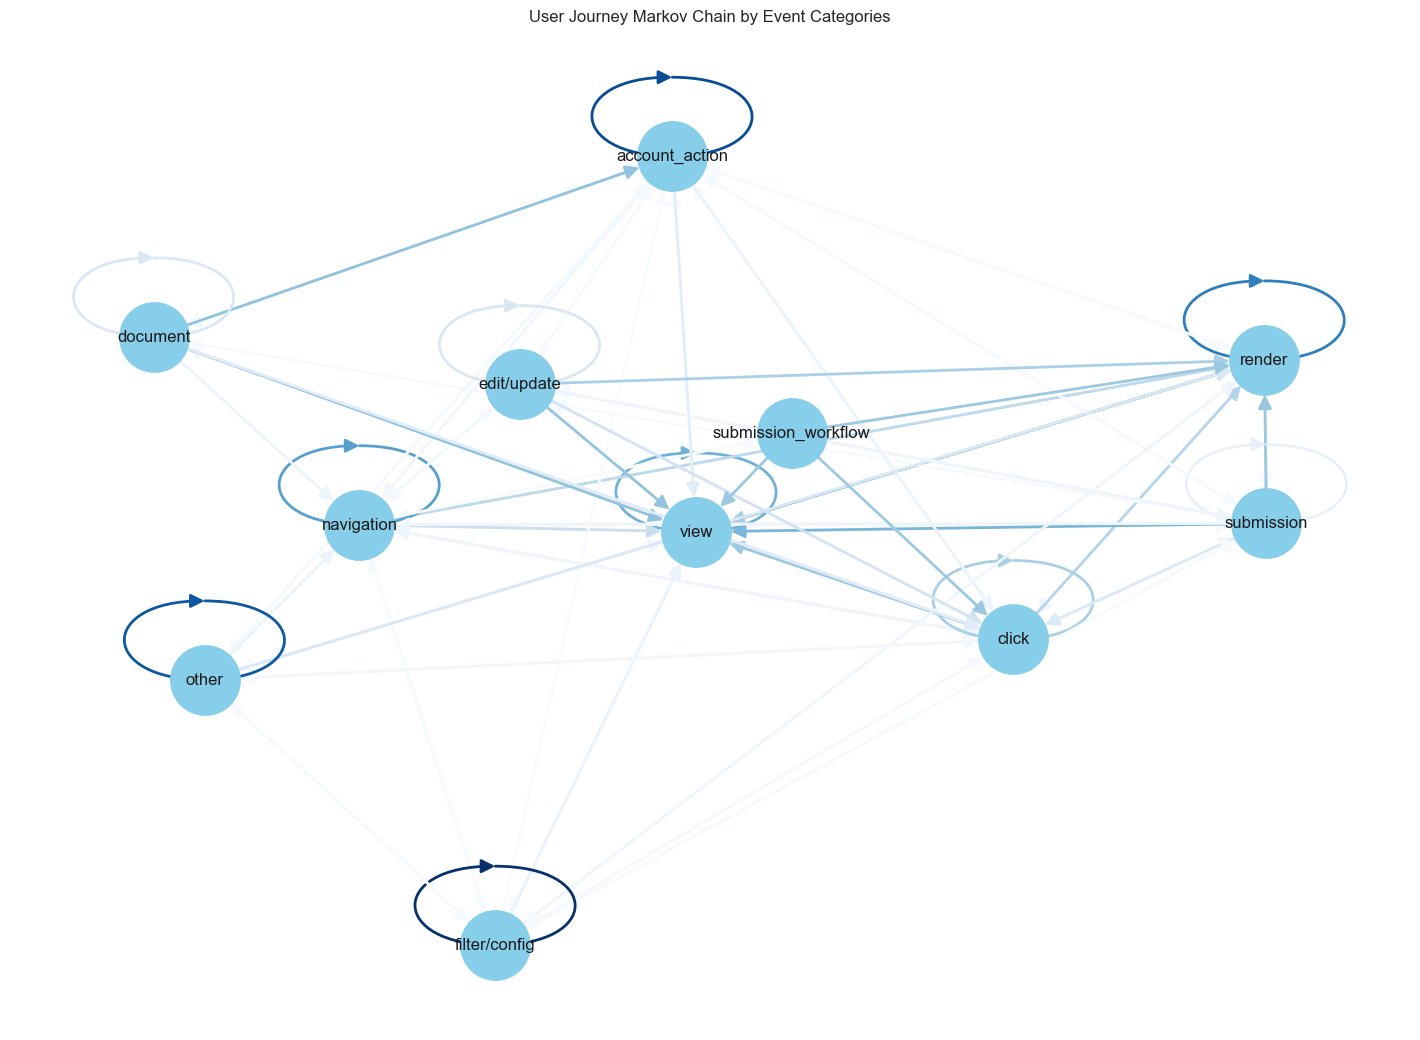

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict

# Step 1: Enhanced Categorization (if not already done)
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply Enhanced Categorization
df_sampled_events['enhanced_category'] = df_sampled_events['event_type'].apply(enhanced_categorize_event)

# Step 2: Prepare Data (Order by User and Session)
df_sampled_events['event_time'] = pd.to_datetime(df_sampled_events['event_time'])
df_sampled_events = df_sampled_events.sort_values(by=['user_id', 'session_id', 'event_time'])

# Step 3: Build Event Category Sequences
category_sequences = df_sampled_events.groupby(['user_id', 'session_id'])['enhanced_category'].apply(list).reset_index()

# Step 4: Build Markov Transition Matrix for Categories
category_transition_counts = defaultdict(lambda: defaultdict(int))

for categories in category_sequences['enhanced_category']:
    for i in range(len(categories) - 1):
        current_category = categories[i]
        next_category = categories[i + 1]
        category_transition_counts[current_category][next_category] += 1

# Convert to DataFrame
category_transition_df = pd.DataFrame(category_transition_counts).fillna(0)

# Normalize to Get Transition Probabilities
category_transition_matrix = category_transition_df.div(category_transition_df.sum(axis=1), axis=0)

# Step 5: Visualize the Markov Chain (Category Level)
G = nx.DiGraph()

for from_category, transitions in category_transition_matrix.iterrows():
    for to_category, prob in transitions.items():
        if prob > 0:
            G.add_edge(from_category, to_category, weight=prob)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)
edge_weights = [G[u][v]['weight'] * 5 for u, v in G.edges()]

nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2500, 
        edge_color=edge_weights, width=2, edge_cmap=plt.cm.Blues, arrowsize=20)
plt.title("User Journey Markov Chain by Event Categories")
plt.show()

# Step 6: Predict Next Best Category
def predict_next_category(current_category, category_transition_matrix):
    if current_category in category_transition_matrix.index:
        next_category = category_transition_matrix.loc[current_category].idxmax()
        prob = category_transition_matrix.loc[current_category].max()
        return next_category, prob
    else:
        return "No Prediction", 0




In [104]:
import pandas as pd
from collections import Counter

# Step 1: Build Event Sequences per User Session
df_sampled_events['event_time'] = pd.to_datetime(df_sampled_events['event_time'])
df_sampled_events = df_sampled_events.sort_values(by=['user_id', 'session_id', 'event_time'])

# Apply Enhanced Categorization if not already done
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply categorization
df_sampled_events['enhanced_category'] = df_sampled_events['event_type'].apply(enhanced_categorize_event)

# Step 2: Create User Journey Sequences
user_journeys = df_sampled_events.groupby(['user_id', 'session_id'])['enhanced_category'].apply(list).reset_index()

# Step 3: Convert Sequences into Readable Format
user_journeys['journey_str'] = user_journeys['enhanced_category'].apply(lambda x: ' -> '.join(x))

# Step 4: Count Journey Frequencies
journey_counter = Counter(user_journeys['journey_str'])

# Step 5: Extract Top 10 Journeys
top_10_journeys = journey_counter.most_common(10)

# Step 6: Display the Top 10 User Journeys
print("Top 10 User Journeys (Most Frequent Paths):")
for idx, (journey, count) in enumerate(top_10_journeys, 1):
    print(f"{idx}. {journey} — Count: {count}")


Top 10 User Journeys (Most Frequent Paths):
1. render — Count: 19157
2. view — Count: 17804
3. navigation — Count: 6793
4. click — Count: 4354
5. render -> render — Count: 2987
6. view -> render — Count: 1571
7. render -> view — Count: 1499
8. view -> view — Count: 1459
9. submission — Count: 1025
10. render -> render -> render — Count: 592


# Appendix V: Markov Transition Matrix and Drop Off Rates

In [238]:
import pandas as pd

# Step 1: Prepare Data with Enhanced Categories
df_sampled_events['event_time'] = pd.to_datetime(df_sampled_events['event_time'])

# Enhanced Categorization Function (if not already applied)
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply enhanced categorization
df_sampled_events['enhanced_category'] = df_sampled_events['event_type'].apply(enhanced_categorize_event)

# Step 2: Sort by Session and Time
df_sampled_events = df_sampled_events.sort_values(by=['session_id', 'event_time'])

# Step 3: Create Sequential Pairs for Markov Chain
df_sampled_events['next_category'] = df_sampled_events.groupby('session_id')['enhanced_category'].shift(-1)

# Drop rows where next_category is NaN (end of session)
df_transitions = df_sampled_events.dropna(subset=['next_category'])

# Step 4: Calculate Transition Probabilities
transition_counts = df_transitions.groupby(['enhanced_category', 'next_category']).size().reset_index(name='count')
total_counts = transition_counts.groupby('enhanced_category')['count'].transform('sum')
transition_counts['probability'] = transition_counts['count'] / total_counts

# Final Markov Transition Matrix
markov_df = transition_counts.rename(columns={'enhanced_category': 'source_category', 'next_category': 'target_category'})



In [242]:
import pandas as pd

# Function to calculate drop-off rates considering exits and including self-transitions
def calculate_refined_drop_offs(markov_df):
    # Step 1: Count total transitions per source category
    total_transitions = markov_df.groupby('source_category')['probability'].sum().reset_index()
    total_transitions.rename(columns={'probability': 'total_probability'}, inplace=True)

    # Step 2: Merge to get total transitions for normalization
    merged_df = pd.merge(markov_df, total_transitions, on='source_category')

    # Step 3: Calculate adjusted drop-off rate
    # Drop-off occurs when there's no valid transition or user exits after the event
    merged_df['drop_off_rate'] = 1 - (merged_df['probability'] / merged_df['total_probability'])

    # Step 4: Sort by drop-off rate for top drop-off points
    drop_offs = merged_df.sort_values(by='drop_off_rate', ascending=False)

    return drop_offs[['source_category', 'target_category', 'probability', 'drop_off_rate']]

# Example usage with your Markov DataFrame
drop_offs = calculate_refined_drop_offs(markov_df)


# Appendix W : Bottlenecks and Restrictions in Event Journeys

Identified Bottlenecks:
   enhanced_category        next_category  count  probability
72            render  submission_workflow      1     0.000023
96              view  submission_workflow      1     0.000028
19             click  submission_workflow      1     0.000121
64            render       account_action      8     0.000180
80        submission                other      1     0.000482
..               ...                  ...    ...          ...
22          document                click     23     0.140244
61             other               render     66     0.171875
45     filter/config                 view    117     0.185127
31       edit/update                click    108     0.187175
34       edit/update               render    113     0.195841

[76 rows x 4 columns]


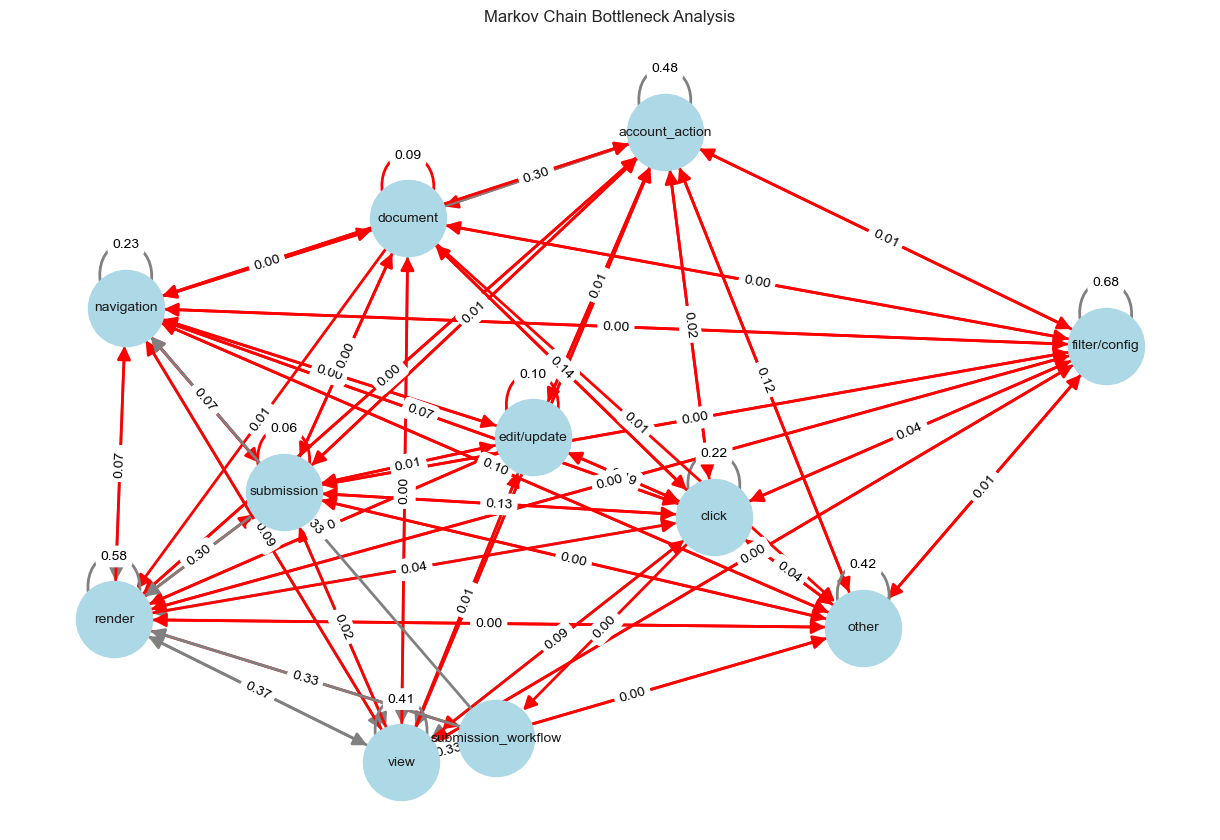

In [128]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Step 1: Enhanced Event Categorization
def enhanced_categorize_event(event):
    if 'session_start' in event or 'session_end' in event or 'application-window-opened' in event:
        return 'navigation'
    elif '::view' in event or 'layout:render' in event:
        return 'view'
    elif 'render' in event:
        return 'render'
    elif 'click' in event and 'submit' not in event and 'edit' not in event:
        return 'click'
    elif 'submit-click' in event:
        return 'submission'
    elif 'edit-click' in event or 'add-click' in event or 'create-document-click' in event:
        return 'edit/update'
    elif 'filter' in event or 'configurable-table' in event:
        return 'filter/config'
    elif 'document' in event:
        return 'document'
    elif 'account' in event:
        return 'account_action'
    elif 'action-center' in event:
        return 'action_center'
    elif 'submission' in event or 'policy' in event or 'exposures' in event:
        return 'submission_workflow'
    else:
        return 'other'

# Apply enhanced categorization
df_sampled_events['enhanced_category'] = df_sampled_events['event_type'].apply(enhanced_categorize_event)

# Step 2: Build Markov Chain Based on Enhanced Categories
def build_markov_chain(df_events):
    # Sort events by user and timestamp
    df_events = df_events.sort_values(['user_id', 'event_time'])

    # Create next event category for transitions
    df_events['next_category'] = df_events.groupby('user_id')['enhanced_category'].shift(-1)

    # Drop rows with no next category (end of session)
    df_transitions = df_events.dropna(subset=['next_category'])

    # Count transitions between categories
    transition_counts = df_transitions.groupby(['enhanced_category', 'next_category']).size().reset_index(name='count')

    # Calculate transition probabilities
    total_counts = transition_counts.groupby('enhanced_category')['count'].transform('sum')
    transition_counts['probability'] = transition_counts['count'] / total_counts

    return transition_counts

# Step 3: Identify Bottlenecks
def identify_bottlenecks(transition_df, drop_threshold=0.2):
    bottlenecks = transition_df[transition_df['probability'] < drop_threshold]
    bottlenecks = bottlenecks.sort_values(by='probability')
    return bottlenecks

# Step 4: Visualize Bottlenecks Using a Directed Graph
def visualize_markov_bottlenecks(transition_df, bottlenecks):
    G = nx.DiGraph()

    # Add all transitions
    for _, row in transition_df.iterrows():
        G.add_edge(row['enhanced_category'], row['next_category'], weight=row['probability'])

    # Highlight bottlenecks in red
    edge_colors = ['red' if (u, v) in list(zip(bottlenecks['enhanced_category'], bottlenecks['next_category'])) else 'grey'
                   for u, v in G.edges()]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10,
            arrowsize=20, edge_color=edge_colors, width=2)
    edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    plt.title('Markov Chain Bottleneck Analysis')
    plt.show()

# Example Usage
# Build the Markov chain
markov_df = build_markov_chain(df_sampled_events)

# Identify bottlenecks with a drop-off threshold of 0.2
bottlenecks_df = identify_bottlenecks(markov_df, drop_threshold=0.2)

# Display bottlenecks
print("Identified Bottlenecks:")
print(bottlenecks_df)

# Visualize the Markov Chain with bottlenecks highlighted
visualize_markov_bottlenecks(markov_df, bottlenecks_df)


Top 15 Bottlenecks by Drop-Off Rate:
   enhanced_category        next_category  probability  drop_off_rate
72            render  submission_workflow     0.000023       0.999977
96              view  submission_workflow     0.000028       0.999972
19             click  submission_workflow     0.000121       0.999879
64            render       account_action     0.000180       0.999820
80        submission                other     0.000482       0.999518
67            render        filter/config     0.000518       0.999482
48        navigation             document     0.000840       0.999160
93              view                other     0.000853       0.999147
78        submission        filter/config     0.000965       0.999035
69            render                other     0.001396       0.998604
44     filter/config           submission     0.001582       0.998418
39     filter/config             document     0.001582       0.998418
89              view             document     0.00196

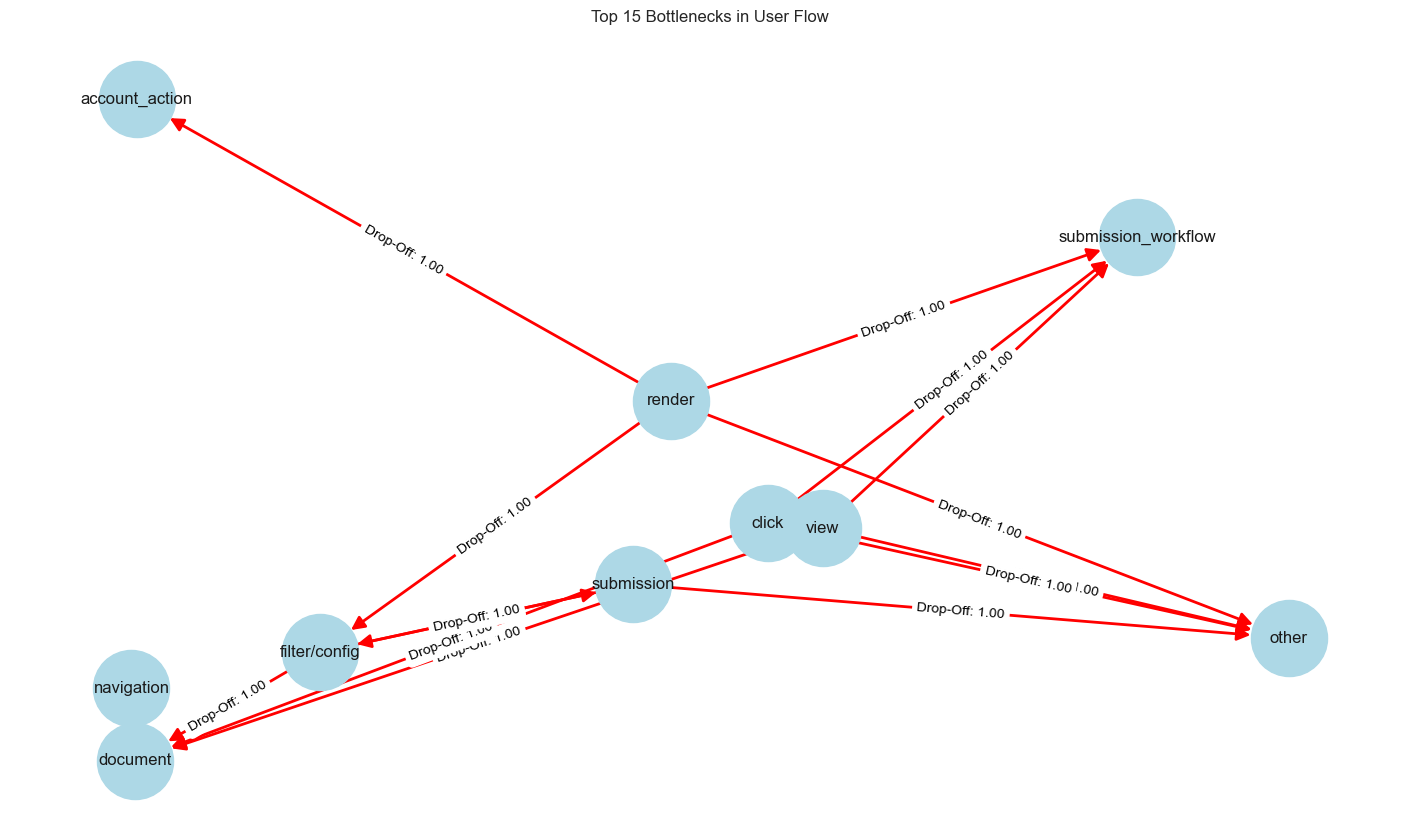

In [130]:
# Step 1: Identify Bottlenecks and Sort by Drop-Off Rate
def identify_and_sort_bottlenecks(transition_df, drop_threshold=0.2):
    # Calculate drop-off rate as 1 - transition probability
    transition_df['drop_off_rate'] = 1 - transition_df['probability']

    # Filter bottlenecks where drop-off rate exceeds the threshold
    bottlenecks = transition_df[transition_df['drop_off_rate'] > drop_threshold]

    # Sort by drop-off rate descending
    bottlenecks_sorted = bottlenecks.sort_values(by='drop_off_rate', ascending=False)

    return bottlenecks_sorted

# Step 2: Generate Top 15 Bottlenecks
bottlenecks_sorted = identify_and_sort_bottlenecks(markov_df, drop_threshold=0.2)

# Get the Top 15 bottlenecks
top_15_bottlenecks = bottlenecks_sorted.head(15)

# Display Top 15 Bottlenecks
print("Top 15 Bottlenecks by Drop-Off Rate:")
print(top_15_bottlenecks[['enhanced_category', 'next_category', 'probability', 'drop_off_rate']])

# Step 3: Visualize the Top 15 Bottlenecks
import networkx as nx
import matplotlib.pyplot as plt

def visualize_top_bottlenecks(bottlenecks_df):
    G = nx.DiGraph()

    # Add top 15 bottleneck transitions to the graph
    for _, row in bottlenecks_df.iterrows():
        G.add_edge(row['enhanced_category'], row['next_category'], weight=row['drop_off_rate'])

    # Draw the graph
    plt.figure(figsize=(14, 8))
    pos = nx.spring_layout(G, seed=42)
    edge_colors = ['red' if d['weight'] > 0.5 else 'orange' for u, v, d in G.edges(data=True)]
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue',
            arrowsize=20, edge_color=edge_colors, width=2)
    edge_labels = {(u, v): f"Drop-Off: {d['weight']:.2f}" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
    plt.title('Top 15 Bottlenecks in User Flow')
    plt.show()

# Visualize the Top 15 Bottlenecks
visualize_top_bottlenecks(top_15_bottlenecks)


# Appendix X: Top 3 Next-Step Actions based on Previous Actions

Next Best Actions for Each Enhanced Category:
      enhanced_category   next_category  count  probability  drop_off_rate
0         filter/config   filter/config    429     0.678797       0.321203
1                render          render  25710     0.578937       0.421063
2        account_action  account_action    567     0.477273       0.522727
3           edit/update            view    242     0.419411       0.580589
4                 other           other    160     0.416667       0.583333
5            submission            view    851     0.410516       0.589484
6                  view            view  14414     0.409826       0.590174
7                 click            view   3343     0.403646       0.596354
8                  view          render  12968     0.368713       0.631287
9              document            view     59     0.359756       0.640244
10           navigation          render   3235     0.339561       0.660439
11  submission_workflow      navigation      1     0.3

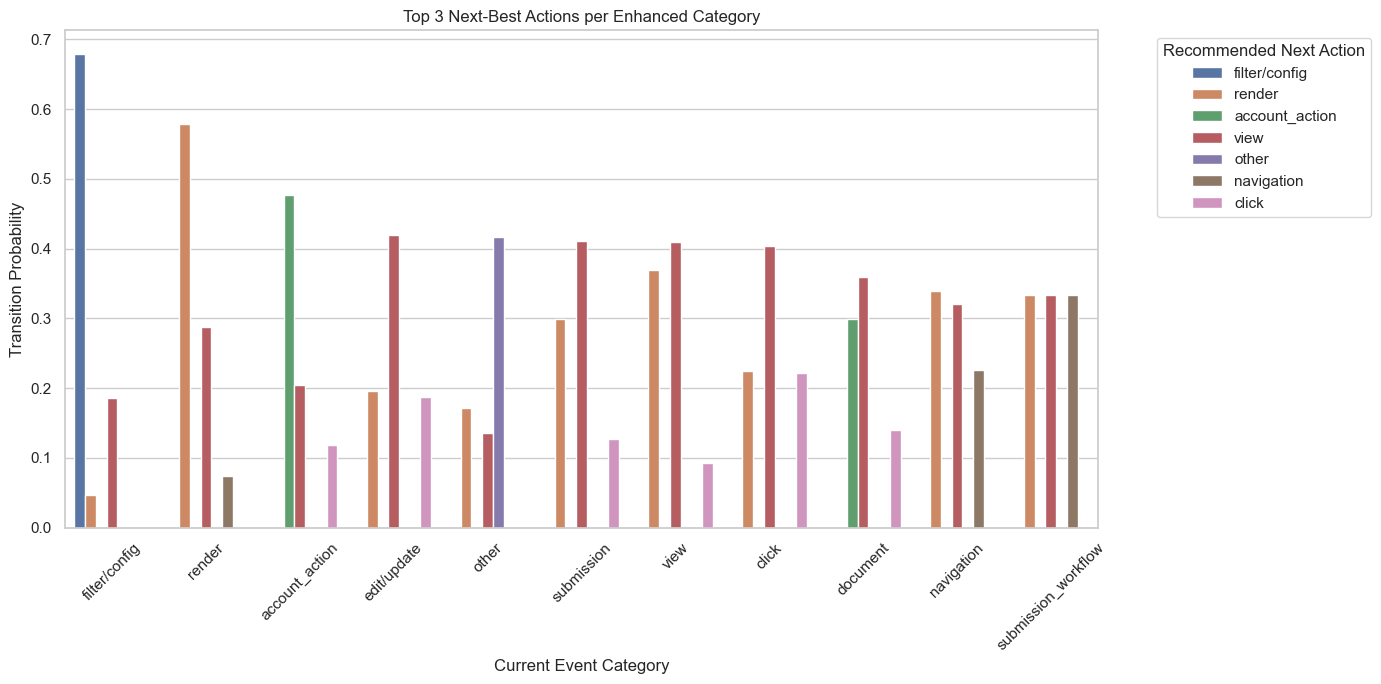

In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to get the next-best actions
def next_best_actions(markov_df, top_n=3):
    # Sort by highest probability
    next_actions = markov_df.sort_values(by='probability', ascending=False)

    # Group by source event and select top N next actions
    next_best = next_actions.groupby('enhanced_category').head(top_n).reset_index(drop=True)

    return next_best

# Apply the function to get top 3 next actions per category
top_next_actions = next_best_actions(markov_df, top_n=3)

# Display the Recommendations
print("Next Best Actions for Each Enhanced Category:")
print(top_next_actions)

# Visualization: Bar Plot for Top Next Actions
plt.figure(figsize=(14, 7))
sns.barplot(data=top_next_actions, x='enhanced_category', y='probability', hue='next_category')
plt.title("Top 3 Next-Best Actions per Enhanced Category")
plt.ylabel("Transition Probability")
plt.xlabel("Current Event Category")
plt.legend(title='Recommended Next Action', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
